In [1]:

!git clone https://github.com/MarsImmortal/neural_factorization_machine.git


Cloning into 'neural_factorization_machine'...
remote: Enumerating objects: 208, done.
remote: Counting objects: 100% (2/2), done.
remote: Total 208 (delta 1), reused 1 (delta 1), pack-reused 206 (from 1)
Receiving objects: 100% (208/208), 69.62 MiB | 15.39 MiB/s, done.
Resolving deltas: 100% (99/99), done.
Updating files: 100% (32/32), done.


In [2]:
%cd neural_factorization_machine

/content/neural_factorization_machine


In [ ]:
import numpy as np
import os

class LoadData(object):
    '''given the path of data, return the data format for DeepFM
    :param path
    return:
    Train_data: a dictionary, 'Y' refers to a list of y values; 'X' refers to a list of features_M dimension vectors with 0 or 1 entries
    Test_data: same as Train_data
    Validation_data: same as Train_data
    '''

    def __init__(self, path, dataset, loss_type):
        self.path = path + dataset + "/"
        self.trainfile = self.path + dataset +".train.libfm"
        self.testfile = self.path + dataset + ".test.libfm"
        self.validationfile = self.path + dataset + ".validation.libfm"
        self.features_M = self.map_features()
        self.Train_data, self.Validation_data, self.Test_data = self.construct_data(loss_type)

    def map_features(self):
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.testfile)
        self.read_features(self.validationfile)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def construct_data(self, loss_type):
        X_, Y_, Y_for_logloss = self.read_data(self.trainfile)
        Train_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        X_, Y_, Y_for_logloss = self.read_data(self.validationfile)
        Validation_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        X_, Y_, Y_for_logloss = self.read_data(self.testfile)
        Test_data = self.construct_dataset(X_, Y_for_logloss if loss_type == 'log_loss' else Y_)
        return Train_data, Validation_data, Test_data

    def read_data(self, file):
        X_ = []
        Y_ = []
        Y_for_logloss = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(float(items[0]))
                v = 1.0 if float(items[0]) > 0 else 0.0
                Y_for_logloss.append(v)
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        return X_, Y_, Y_for_logloss

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic

    def truncate_features(self):
        num_variable = len(self.Train_data['X'][0])
        for i in range(len(self.Train_data['X'])):
            num_variable = min(num_variable, len(self.Train_data['X'][i]))
        for i in range(len(self.Train_data['X'])):
            self.Train_data['X'][i] = self.Train_data['X'][i][:num_variable]
        for i in range(len(self.Validation_data['X'])):
            self.Validation_data['X'][i] = self.Validation_data['X'][i][:num_variable]
        for i in range(len(self.Test_data['X'])):
            self.Test_data['X'][i] = self.Test_data['X'][i][:num_variable]
        return num_variable


In [ ]:
import tensorflow as tf
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.loss_type = loss_type
        self.activation = activation

        self.embedding = tf.keras.layers.Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = [tf.keras.layers.Dense(layer_size, activation=activation) for layer_size in layers]
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [tf.keras.layers.Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output

    def get_config(self):
        return {
            'feature_dim': self.feature_dim,
            'hidden_factor': self.hidden_factor,
            'layers': self.layers_config,
            'keep_prob': self.keep_prob,
            'loss_type': self.loss_type,
            'activation': self.activation,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import mean_squared_error, log_loss
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load data
path = 'data/'
dataset = 'frappe'
loss_type = 'square_loss'  # or 'log_loss'

# Initialize data loader
loader = LoadData(path, dataset, loss_type)
feature_dim = loader.features_M
hidden_factor = 64
layers = [64]
keep_prob = [0.8, 0.5]

# Create model
model = NeuralFM(
    feature_dim=feature_dim,
    hidden_factor=hidden_factor,
    layers=layers,
    keep_prob=keep_prob,
    loss_type=loss_type,
    activation='relu'
)

# Compile model
optimizer = Adagrad(learning_rate=0.05)
model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy' if loss_type == 'log_loss' else 'mean_squared_error'
)

# Prepare data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)  # Adjust buffer size if necessary
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

# Create datasets with batch size
batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define early stopping and TensorBoard callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Train model with callbacks
history = model.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save the trained model in Keras format
model.save('neural_fm_model.keras')
print("Model saved to neural_fm_model.keras")

# Evaluate model
y_pred = model.predict(test_dataset)
if loss_type == 'log_loss':
    score = log_loss(y_test, y_pred)
else:
    score = mean_squared_error(y_test, y_pred)

print(f"Test {loss_type} score: {score}")

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot learning curves (if applicable)
# Example: Accuracy curves if you have accuracy metrics
if 'accuracy' in history.history:
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

# Predictions vs True Values (for a small subset)
sample_size = 100
sample_indices = np.random.choice(len(y_test), size=sample_size, replace=False)
y_test_sample = y_test[sample_indices]
y_pred_sample = y_pred[sample_indices]

plt.figure(figsize=(12, 6))
plt.scatter(y_test_sample, y_pred_sample, alpha=0.5)
plt.plot([min(y_test_sample), max(y_test_sample)], [min(y_test_sample), max(y_test_sample)], color='red', linestyle='--')
plt.title('Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()


Num GPUs Available:  0
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_25', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.6302 - val_loss: 0.3654
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.3376 - val_loss: 0.3166
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.3008 - val_loss: 0.2978
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.2729 - val_loss: 0.2736
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.2432 - val_loss: 0.2618
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.2170 - val_loss: 0.2396
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.1940 - val_loss: 0.2277
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 0.1746 - val_loss: 0.2199
Epoch 9/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.1585 - val_loss: 0.2122
Epoch 10/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.1445 - val_loss: 0.2052
Epoch 11/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.1315 - val_loss: 0.2014
Epoch 12/

InvalidArgumentError: Graph execution error:

Detected at node cond/adagrad/cond/cond/GatherV2_1 defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-83-b3ff337314b7>", line 83, in <cell line: 83>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 318, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 73, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 282, in apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 165, in apply

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 216, in _tf_apply

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 200, in _common_apply

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 824, in cond

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 778, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 770, in call_fn

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/core.py", line 784, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/core.py", line 214, in cond

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 202, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/loss_scale_optimizer.py", line 175, in _stateful_handle_finite_grads

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 351, in apply

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py", line 405, in _backend_apply_gradients

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 119, in _backend_update_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 135, in _distributed_tf_update_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/optimizer.py", line 132, in apply_grad_to_update_var

  File "/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/adagrad.py", line 95, in update_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/numpy.py", line 5510, in divide

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/sparse.py", line 770, in sparse_wrapper

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/sparse.py", line 758, in func_for_union_indices

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/sparse.py", line 139, in indexed_slices_union_indices_and_values

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/sparse.py", line 142, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/sparse.py", line 136, in values_for_union

indices[0] = 21279 is not in [0, 1281)
	 [[{{node cond/adagrad/cond/cond/GatherV2_1}}]] [Op:__inference_one_step_on_iterator_3670732]

# RMSE vs dimentionality on Frappe
(Prediction Error)

Num GPUs Available:  1
Feature dimension: 5382
Training model with embedding dimension: 4
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


3157/3157 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - loss: 0.5820 - val_loss: 0.3514
Epoch 2/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.3515 - val_loss: 0.3322
Epoch 3/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.3243 - val_loss: 0.3087
Epoch 4/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.2980 - val_loss: 0.2952
Epoch 5/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.2830 - val_loss: 0.2832
Epoch 6/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.2668 - val_loss: 0.2756
Epoch 7/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.2580 - val_loss: 0.2737
Epoch 8/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2508 - val_loss: 0.2683
Epoch 9/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2451 - val_loss: 0.2666
Epoch 10/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2416 - val_loss: 0.2649
Epoch 11/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2375 - val_loss: 0.2641
Epoch 12/200
3157/3157 ━

RMSE for embedding dimension 4: 0.5078870608360249
Model saved to models/neural_fm_4.h5
Training model with embedding dimension: 8
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


3157/3157 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - loss: 0.5696 - val_loss: 0.3444
Epoch 2/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.3420 - val_loss: 0.3134
Epoch 3/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.2959 - val_loss: 0.2685
Epoch 4/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.2469 - val_loss: 0.2500
Epoch 5/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.2202 - val_loss: 0.2411
Epoch 6/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.2045 - val_loss: 0.2374
Epoch 7/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1945 - val_loss: 0.2359
Epoch 8/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1876 - val_loss: 0.2364
Epoch 9/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.1819 - val_loss: 0.2358
Epoch 10/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1781 - val_loss: 0.2363
Epoch 11/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1739 - val_loss: 0.2362
Epoch 12/200
3157/3157 ━━

RMSE for embedding dimension 8: 0.4865583558835009
Model saved to models/neural_fm_8.h5
Training model with embedding dimension: 16
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


3157/3157 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.5679 - val_loss: 0.3391
Epoch 2/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.3245 - val_loss: 0.2705
Epoch 3/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.2420 - val_loss: 0.2299
Epoch 4/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.1892 - val_loss: 0.2151
Epoch 5/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.1602 - val_loss: 0.2092
Epoch 6/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1419 - val_loss: 0.2089
Epoch 7/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.1301 - val_loss: 0.2113
Epoch 8/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1211 - val_loss: 0.2137
Epoch 9/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1142 - val_loss: 0.2154
Epoch 10/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1091 - val_loss: 0.2178
Epoch 11/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.1051 - val_loss: 0.2218
Epoch 12/200
3157/3157 ━━

RMSE for embedding dimension 16: 0.45718700595349104
Model saved to models/neural_fm_16.h5
Training model with embedding dimension: 32
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


3157/3157 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.5534 - val_loss: 0.3150
Epoch 2/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2844 - val_loss: 0.2280
Epoch 3/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1836 - val_loss: 0.1939
Epoch 4/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1342 - val_loss: 0.1882
Epoch 5/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.1065 - val_loss: 0.1913
Epoch 6/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0885 - val_loss: 0.1928
Epoch 7/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0751 - val_loss: 0.1975
Epoch 8/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0667 - val_loss: 0.2067
Epoch 9/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0600 - val_loss: 0.2103
Epoch 10/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0543 - val_loss: 0.2143
Epoch 11/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0502 - val_loss: 0.2195
Epoch 12/200
3157/3157 ━━━

RMSE for embedding dimension 32: 0.43238902743662405
Model saved to models/neural_fm_32.h5
Training model with embedding dimension: 64
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


3157/3157 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - loss: 0.5334 - val_loss: 0.2907
Epoch 2/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.2508 - val_loss: 0.1995
Epoch 3/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.1464 - val_loss: 0.1726
Epoch 4/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0944 - val_loss: 0.1697
Epoch 5/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0655 - val_loss: 0.1710
Epoch 6/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0487 - val_loss: 0.1721
Epoch 7/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0382 - val_loss: 0.1749
Epoch 8/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0319 - val_loss: 0.1740
Epoch 9/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0270 - val_loss: 0.1762
Epoch 10/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0234 - val_loss: 0.1741
Epoch 11/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0209 - val_loss: 0.1736
Epoch 12/200
3157/3157 ━━━━━━

RMSE for embedding dimension 64: 0.41335416252713914
Model saved to models/neural_fm_64.h5
Training model with embedding dimension: 128
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


3157/3157 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.5230 - val_loss: 0.2553
Epoch 2/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.2136 - val_loss: 0.1767
Epoch 3/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.1124 - val_loss: 0.1556
Epoch 4/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0651 - val_loss: 0.1493
Epoch 5/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0429 - val_loss: 0.1481
Epoch 6/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - loss: 0.0320 - val_loss: 0.1403
Epoch 7/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0257 - val_loss: 0.1369
Epoch 8/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0213 - val_loss: 0.1344
Epoch 9/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0183 - val_loss: 0.1324
Epoch 10/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - loss: 0.0162 - val_loss: 0.1305
Epoch 11/200
3157/3157 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0143 - val_loss: 0.1293
Epoch 12/200
3157/3157 ━

RMSE for embedding dimension 128: 0.34162220158058715
Model saved to models/neural_fm_128.h5


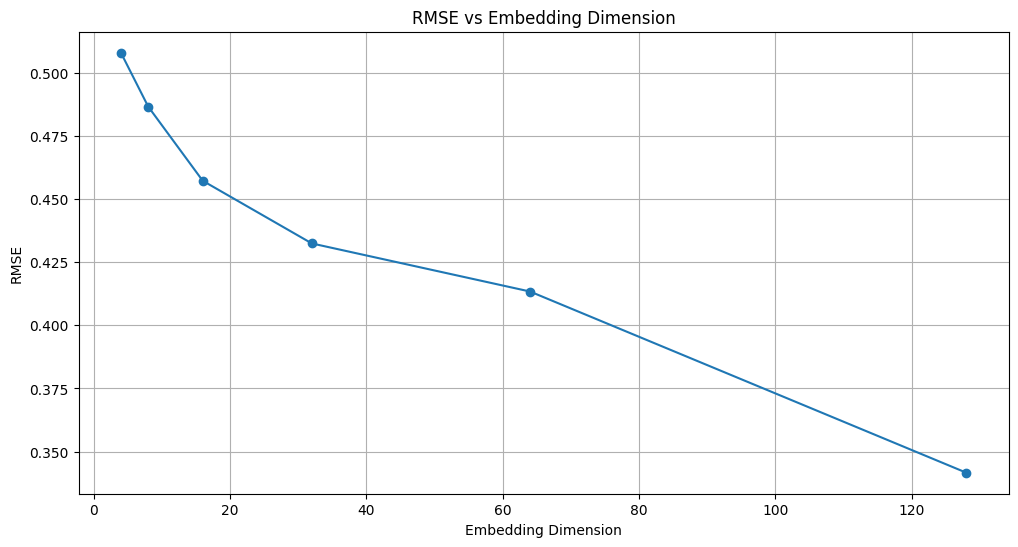

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam  # Try Adam optimizer instead
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load data using your LoadData class
path = 'data/'
dataset = 'frappe'
loss_type = 'square_loss'  # Or 'log_loss' for classification

# Initialize the data loader
loader = LoadData(path, dataset, loss_type)
feature_dim = loader.features_M  # Number of unique features
print(f"Feature dimension: {feature_dim}")

# Prepare data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

# Create TensorFlow datasets
def create_dataset(X, y, batch_size=64, shuffle=True):  # Reduced batch size
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

# Create datasets
train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val, shuffle=False)
test_dataset = create_dataset(X_test, y_test, shuffle=False)

# List of embedding dimensions to test
embedding_dims = [4, 8, 16, 32, 64, 128]

# Store results for plotting
rmse_results = []
accuracy_results = []

for hidden_factor in embedding_dims:
    print(f"Training model with embedding dimension: {hidden_factor}")

    # Create a new instance of NeuralFM
    model = NeuralFM(
        feature_dim=feature_dim,
        hidden_factor=hidden_factor,
        layers=[64],
        keep_prob=[0.8, 0.5],
        loss_type=loss_type,
        activation='relu'
    )

    # Compile the model with a different optimizer
    optimizer = Adam(learning_rate=0.001)  # Using Adam instead of Adagrad
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy' if loss_type == 'log_loss' else 'mean_squared_error',
        metrics=['accuracy'] if loss_type == 'log_loss' else []
    )

    # Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
        callbacks=[early_stopping],
        verbose=1
    )

    # Evaluate the model
    y_pred = model.predict(test_dataset)
    if loss_type == 'log_loss':
        y_pred_binary = np.round(y_pred)
        accuracy = accuracy_score(y_test, y_pred_binary)
        accuracy_results.append(accuracy)
        print(f"Accuracy for embedding dimension {hidden_factor}: {accuracy}")
    else:
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        rmse_results.append(rmse)
        print(f"RMSE for embedding dimension {hidden_factor}: {rmse}")

    # Save the model
    model_save_path = f'models/neural_fm_{hidden_factor}.h5'
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

# Plot RMSE vs Embedding Dimension (for regression)
if loss_type == 'square_loss':
    plt.figure(figsize=(12, 6))
    plt.plot(embedding_dims, rmse_results, marker='o')
    plt.title('RMSE vs Embedding Dimension')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

# Plot Accuracy vs Embedding Dimension (for classification)
if loss_type == 'log_loss':
    plt.figure(figsize=(12, 6))
    plt.plot(embedding_dims, accuracy_results, marker='o')
    plt.title('Accuracy vs Embedding Dimension')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()


In [ ]:
from tensorflow.keras.models import load_model
model_binary = load_model('neural_fm_model.keras', custom_objects={'NeuralFM': NeuralFM})


# Evaluating on the basis of activation Fucntions

In [ ]:
# List of activation functions to test
activation_functions = ['relu', 'sigmoid', 'tanh', 'elu']

# Store results for plotting
loss_results = {act_func: [] for act_func in activation_functions}
validation_loss_results = {act_func: [] for act_func in activation_functions}
scores = []

for activation in activation_functions:
    print(f"Training model with activation function: {activation}")

    # Create NeuralFM model
    model = NeuralFM(
        feature_dim=feature_dim,
        hidden_factor=hidden_factor,
        layers=layers,
        keep_prob=keep_prob,
        loss_type=loss_type,
        activation=activation
    )

    # Compile model
    optimizer = Adagrad(learning_rate=0.05)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy' if loss_type == 'log_loss' else 'mean_squared_error'
    )

    # Define early stopping and TensorBoard callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    tensorboard_callback = TensorBoard(log_dir=f"./logs/{activation}", profile_batch=0)

    # Train model
    history = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
        callbacks=[early_stopping, tensorboard_callback],
        verbose=1
    )

    # Evaluate model
    y_pred = model.predict(test_dataset)
    if loss_type == 'log_loss':
        score = log_loss(y_test, y_pred)
    else:
        score = mean_squared_error(y_test, y_pred)
    scores.append((activation, score))
    print(f"Test {loss_type} score for activation {activation}: {score}")

    # Store training and validation loss
    loss_results[activation] = history.history['loss']
    validation_loss_results[activation] = history.history['val_loss']

    # Save the trained model
    model_save_path = f'models/neural_fm_model_{activation}.keras'
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")
    # add modified neural FM class


Training model with activation function: relu


NameError: name 'layers' is not defined

# train Pre trained model

Num GPUs Available:  0
Epoch 1/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 28s 17ms/step - loss: 1093.7103 - val_loss: 0.3203
Epoch 2/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.2140 - val_loss: 0.2572
Epoch 3/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - loss: 0.1398 - val_loss: 0.2343
Epoch 4/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 43s 15ms/step - loss: 0.1078 - val_loss: 0.2231
Epoch 5/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0909 - val_loss: 0.2151
Epoch 6/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0783 - val_loss: 0.2103
Epoch 7/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0701 - val_loss: 0.2060
Epoch 8/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - loss: 0.0635 - val_loss: 0.2046
Epoch 9/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 0.0585 - val_loss: 0.2024
Epoch 10/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 22s 11ms/step - loss: 0.0537 - val_loss: 0.2021
Epoch 11/30
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0504 -

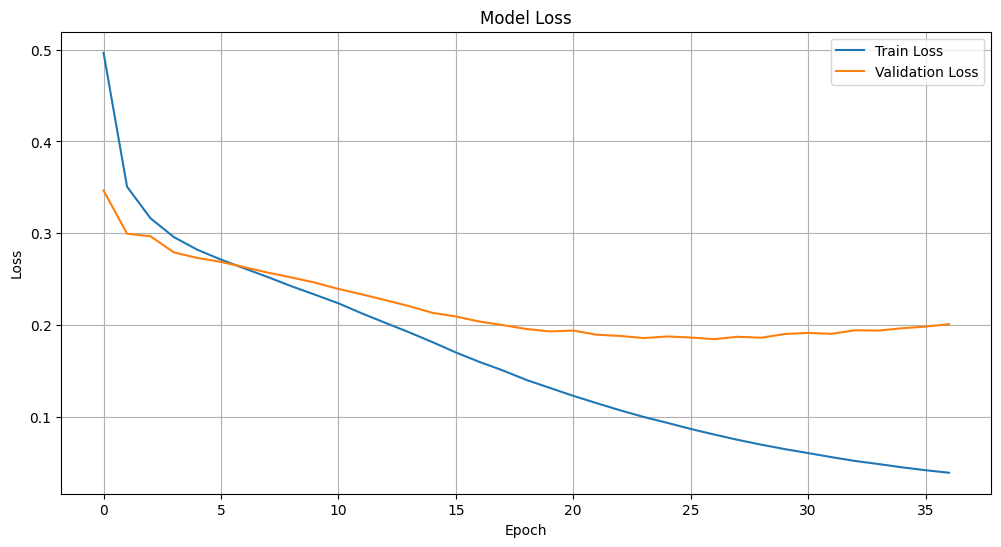

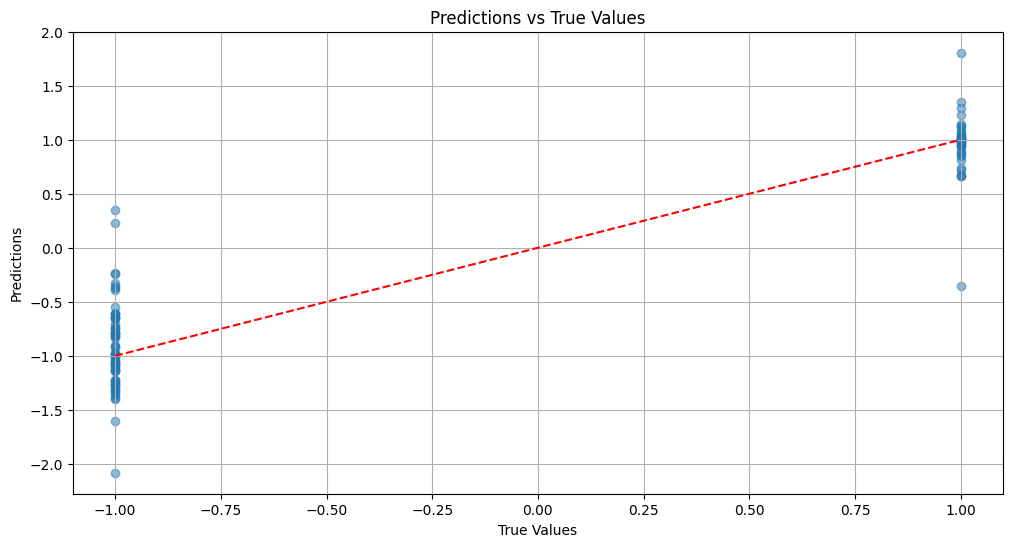

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
from sklearn.metrics import log_loss, mean_squared_error

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow memory growth for GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load the pre-trained model with the custom NeuralFM class
pretrained_model_path = 'neural_fm_model.keras'

# Load the model with custom_objects
model = tf.keras.models.load_model(pretrained_model_path, custom_objects={'NeuralFM': NeuralFM})

# Compile the model with the same optimizer and loss function
optimizer = Adagrad(learning_rate=0.05)
model.compile(optimizer=optimizer, loss='binary_crossentropy' if loss_type == 'log_loss' else 'mean_squared_error')

# Function to prepare data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

# Function to create dataset
def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare data for training, validation, and testing
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define early stopping and TensorBoard callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Continue training the pre-trained model
history_updated = model.fit(
    train_dataset,
    epochs=30,  # You can adjust the number of epochs as needed
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save the updated model
model.save('neural_fm_model_updated.keras')
print("Updated model saved to neural_fm_model_updated.keras")

# Evaluate the model
y_pred = model.predict(test_dataset)

# Flatten y_pred if it's 2D with the second dimension being 1
if y_pred.ndim == 2 and y_pred.shape[1] == 1:
    y_pred = np.squeeze(y_pred)

# Check shapes
print("Shape of y_test:", y_test.shape)
print("Shape of y_pred:", y_pred.shape)

# Calculate the evaluation metric
if loss_type == 'log_loss':
    score = log_loss(y_test, y_pred)
else:
    score = mean_squared_error(y_test, y_pred)

print(f"Test {loss_type} score: {score}")

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Predictions vs True Values for a small subset
sample_size = 100
sample_indices = np.random.choice(len(y_test), size=sample_size, replace=False)
y_test_sample = y_test[sample_indices]
y_pred_sample = y_pred[sample_indices]

plt.figure(figsize=(12, 6))
plt.scatter(y_test_sample, y_pred_sample, alpha=0.5)
plt.plot([min(y_test_sample), max(y_test_sample)], [min(y_test_sample), max(y_test_sample)], color='red', linestyle='--')
plt.title('Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()


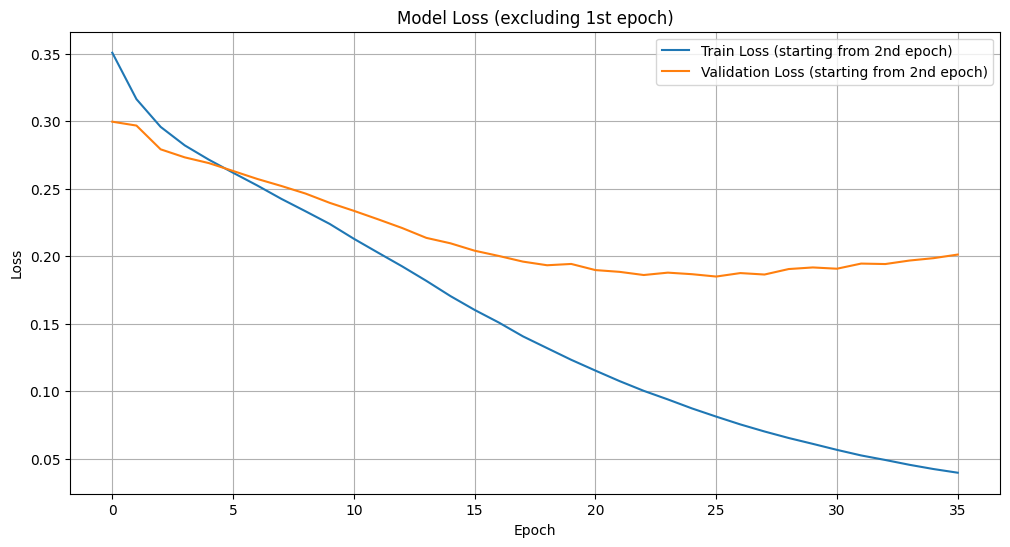

In [ ]:
# After training is complete, modify the history to ignore the first epoch
# Get the loss values starting from the second epoch
train_loss = history_updated.history['loss'][1:]
val_loss = history_updated.history['val_loss'][1:]

# Plot the training & validation loss values starting from the second epoch
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss (starting from 2nd epoch)')
plt.plot(val_loss, label='Validation Loss (starting from 2nd epoch)')
plt.title('Model Loss (excluding 1st epoch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout

# Register your custom model class
@tf.keras.utils.register_keras_serializable()
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.embedding = Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = []
        for layer_size in layers:
            self.hidden_layers.append(Dense(layer_size, activation=activation))
        self.output_layer = Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output


# data Visualisation Frappe and ML-tag (movie lens)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_data_distribution(data, dataset_name='Train'):
    """
    Visualizes data distribution for the given dataset (Train/Validation/Test).

    :param data: Dictionary with 'X' and 'Y' values from the LoadData class
    :param dataset_name: 'Train', 'Validation', or 'Test' to indicate which dataset is being visualized
    """
    # Extract features and labels
    X_data = data['X']
    Y_data = data['Y']

    # Plot label distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(Y_data, bins=2, kde=False)
    plt.title(f'Label Distribution in {dataset_name} Dataset')
    plt.xlabel('Label')
    plt.ylabel('Frequency')
    plt.show()

    # Visualizing the sparsity of the feature matrix
    feature_lengths = [len(x) for x in X_data]

    plt.figure(figsize=(10, 5))
    sns.histplot(feature_lengths, bins=30, kde=False)
    plt.title(f'Feature Vector Length Distribution in {dataset_name} Dataset')
    plt.xlabel('Number of Non-Zero Features per Sample')
    plt.ylabel('Frequency')
    plt.show()


In [ ]:
import numpy as np

def visualize_sparsity_matrix(data, dataset_name='Train', num_samples=100, num_features=None):
    """
    Visualizes a sample of the feature matrix sparsity using a heatmap.

    :param data: Dictionary with 'X' and 'Y' values from the LoadData class
    :param dataset_name: 'Train', 'Validation', or 'Test' to indicate which dataset is being visualized
    :param num_samples: Number of samples to visualize
    :param num_features: Number of features (optional, required for heatmap)
    """
    # Limit the data to the first `num_samples` entries
    X_data = data['X'][:num_samples]

    if num_features is None:
        raise ValueError("You must provide the total number of features as `num_features`.")

    # Create a binary matrix indicating where non-zero entries exist
    binary_matrix = np.zeros((num_samples, num_features))

    for i, sample in enumerate(X_data):
        for feature in sample:
            binary_matrix[i, feature] = 1

    # Plot the sparsity pattern
    plt.figure(figsize=(15, 8))
    sns.heatmap(binary_matrix, cmap='Blues', cbar=False)
    plt.title(f'Sparsity Pattern of Feature Matrix in {dataset_name} Dataset (First {num_samples} Samples)')
    plt.xlabel('Features')
    plt.ylabel('Samples')
    plt.show()



In [ ]:
# loading data
path = 'data/'  # Update this to your actual data path
dataset = 'frappe'  # Replace with your dataset name
loss_type = 'log_loss'  # Or other loss type as needed

# Create an instance of LoadData
loaded_data = LoadData(path, dataset, loss_type)


In [ ]:
# Basic stats about the dataset
def display_data_statistics(data_dict, data_type="Train"):
    print(f"Statistics for {data_type} data:")
    num_samples = len(data_dict['Y'])
    num_features = len(data_dict['X'][0]) if num_samples > 0 else 0
    print(f"Number of samples: {num_samples}")
    print(f"Number of features per sample: {num_features}")
    print(f"First few target values (Y): {data_dict['Y'][:5]}")
    print(f"First few feature sets (X): {data_dict['X'][:5]}")
    print("\n")

display_data_statistics(loaded_data.Train_data, "Train")
display_data_statistics(loaded_data.Validation_data, "Validation")
display_data_statistics(loaded_data.Test_data, "Test")


Statistics for Train data:
Number of samples: 202027
Number of features per sample: 10
First few target values (Y): [1.0, 0.0, 1.0, 0.0, 1.0]
First few feature sets (X): [[243, 1939, 48, 30, 20, 5, 6, 80, 8, 9], [726, 1643, 112, 25, 20, 5, 6, 26, 135, 728], [40, 1386, 38, 12, 4, 5, 6, 7, 8, 9], [249, 3454, 18, 42, 20, 5, 6, 7, 54, 251], [890, 218, 18, 42, 20, 13, 6, 7, 150, 892]]


Statistics for Validation data:
Number of samples: 57722
Number of features per sample: 10
First few target values (Y): [0.0, 0.0, 0.0, 1.0, 0.0]
First few feature sets (X): [[665, 2465, 18, 58, 20, 5, 6, 45, 66, 9], [159, 1684, 24, 25, 20, 5, 6, 26, 161, 210], [351, 1793, 38, 19, 20, 5, 6, 26, 62, 702], [307, 2132, 38, 19, 20, 13, 6, 26, 8, 9], [266, 4264, 112, 58, 20, 5, 6, 45, 66, 9]]


Statistics for Test data:
Number of samples: 28860
Number of features per sample: 10
First few target values (Y): [1.0, 0.0, 0.0, 0.0, 0.0]
First few feature sets (X): [[3817, 3182, 38, 12, 4, 13, 6, 72, 8, 884], [362, 477

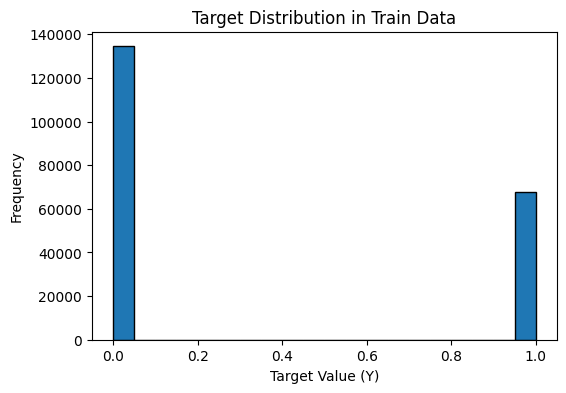

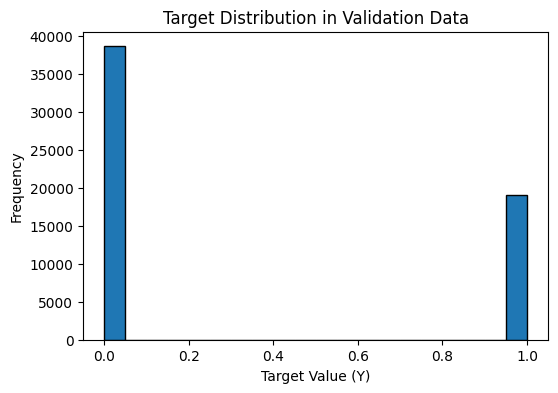

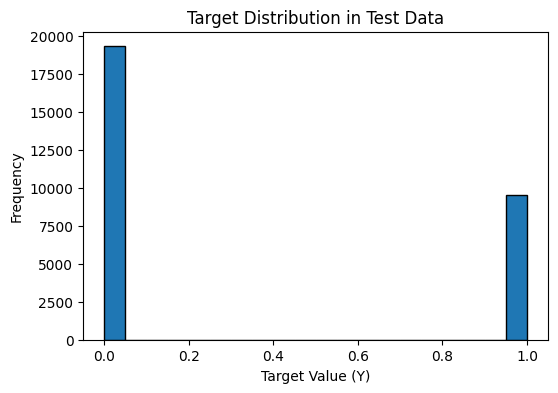

In [ ]:
import matplotlib.pyplot as plt

def plot_target_distribution(data_dict, data_type="Train"):
    plt.figure(figsize=(6,4))
    plt.hist(data_dict['Y'], bins=20, edgecolor='black')
    plt.title(f'Target Distribution in {data_type} Data')
    plt.xlabel('Target Value (Y)')
    plt.ylabel('Frequency')
    plt.show()

plot_target_distribution(loaded_data.Train_data, "Train")
plot_target_distribution(loaded_data.Validation_data, "Validation")
plot_target_distribution(loaded_data.Test_data, "Test")


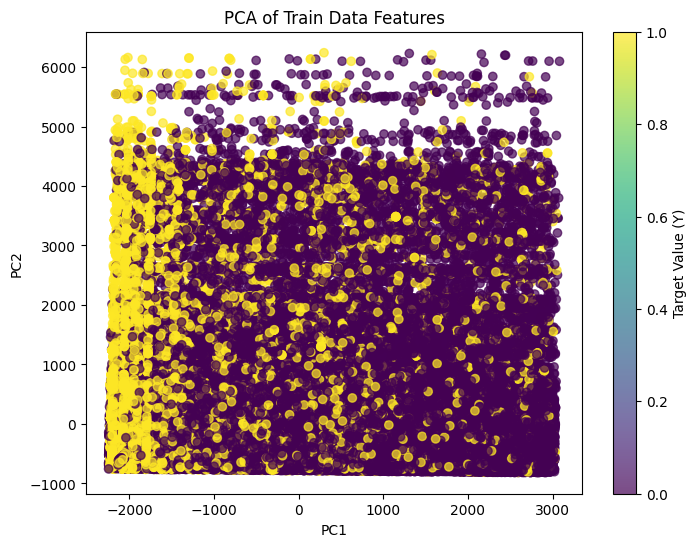

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def plot_feature_pca(data_dict, data_type="Train"):
    X_data = np.array(data_dict['X'])
    pca = PCA(n_components=2)
    X_reduced = pca.fit_transform(X_data)

    plt.figure(figsize=(8, 6))
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=data_dict['Y'], cmap='viridis', alpha=0.7)
    plt.colorbar(label='Target Value (Y)')
    plt.title(f'PCA of {data_type} Data Features')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()

plot_feature_pca(loaded_data.Train_data, "Train")


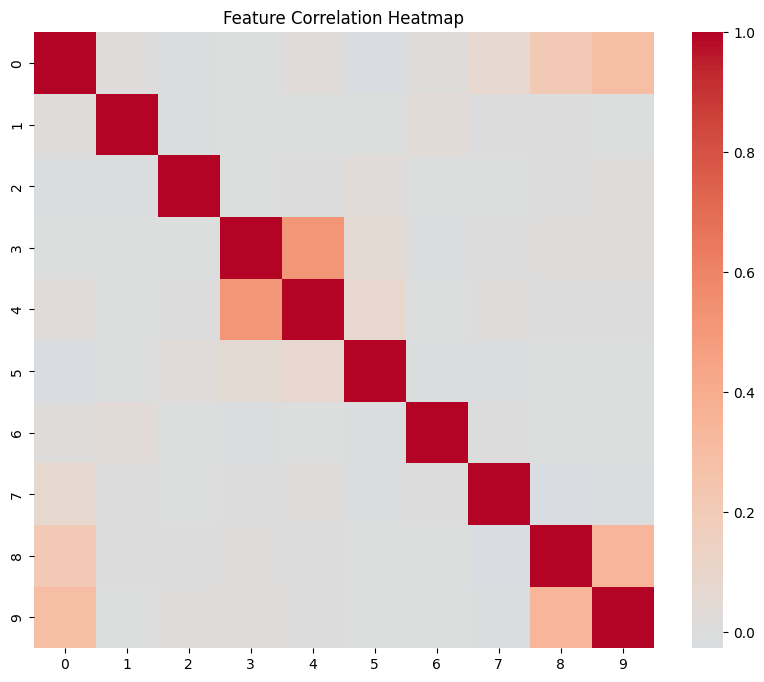

In [ ]:
def plot_correlation_heatmap(data_dict):
    X_data = np.array(data_dict['X'])
    corr_matrix = np.corrcoef(X_data.T)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.show()

plot_correlation_heatmap(loaded_data.Train_data)


In [ ]:
# Load the trained model
loaded_model = tf.keras.models.load_model('neural_fm_model.keras', custom_objects={'NeuralFM': NeuralFM})

# Verify the model's architecture and summary
loaded_model.summary()


Model: "neural_fm_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 10, 64)              │         344,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              66 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 697,354 (2.66 MB)

 Trainable params: 348,674 (1.33 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 348,680 (1.33 MB)

# Attempt to implement multi class NFM

In [51]:
from tensorflow.keras.utils import to_categorical

class LoadData(object):
    def __init__(self, path, dataset, num_classes):
        self.path = path + dataset + "/"
        self.trainfile = self.path + dataset + ".train.libfm"
        self.testfile = self.path + dataset + ".test.libfm"
        self.validationfile = self.path + dataset + ".validation.libfm"
        self.features_M = self.map_features()
        self.num_classes = num_classes
        self.Train_data, self.Validation_data, self.Test_data = self.construct_data()

    def map_features(self):
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.testfile)
        self.read_features(self.validationfile)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def read_data(self, file):
        X_ = []
        Y_ = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(int(items[0]))  # Assuming labels are integers for multiclass
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        # Convert labels to one-hot encoded vectors for multiclass classification
        Y_onehot = to_categorical(Y_, num_classes=self.num_classes)
        return X_, Y_onehot

    def construct_data(self):
        # Prepare data for train, validation, and test sets
        X_train, Y_train = self.read_data(self.trainfile)
        Train_data = self.construct_dataset(X_train, Y_train)

        X_val, Y_val = self.read_data(self.validationfile)
        Validation_data = self.construct_dataset(X_val, Y_val)

        X_test, Y_test = self.read_data(self.testfile)
        Test_data = self.construct_dataset(X_test, Y_test)

        return Train_data, Validation_data, Test_data

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic


In [52]:
import tensorflow as tf

class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, num_classes, activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.num_classes = num_classes

        # Embedding layer for factorization machine
        self.embedding = tf.keras.layers.Embedding(feature_dim, hidden_factor, mask_zero=False)

        # Hidden layers for the neural network
        self.hidden_layers = [tf.keras.layers.Dense(layer_size, activation=activation) for layer_size in layers]

        # Output layer for multiclass classification with softmax activation
        self.output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

        # Dropout layers
        self.dropout_layers = [tf.keras.layers.Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        # Embedding lookup
        x = self.embedding(inputs)

        # FM part: Interaction terms between features
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        # NN part: Apply hidden layers
        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        # Concatenate FM and NN part
        x = tf.concat([x, fm_part], axis=1)

        # Output layer (softmax for multiclass classification)
        output = self.output_layer(x)
        return output


In [53]:
# Initialize data loader
path = 'data/'
dataset = 'frappe'
num_classes = 3  # Example number of classes

# Load data
loader = LoadData(path, dataset, num_classes)
feature_dim = loader.features_M
hidden_factor = 64
layers = [64]
keep_prob = [0.8, 0.5]

# Create NeuralFM model
model = NeuralFM(
    feature_dim=feature_dim,
    hidden_factor=hidden_factor,
    layers=layers,
    keep_prob=keep_prob,
    num_classes=num_classes,
    activation='relu'
)

# Compile model for multiclass classification
optimizer = Adagrad(learning_rate=0.05)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [54]:
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare training, validation, and test data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Train model
history_multiclass = model.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save model
model.save('neural_fm_model_multiclass.keras')


Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - accuracy: 0.7188 - loss: 0.5848 - val_accuracy: 0.8654 - val_loss: 0.3354
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8742 - loss: 0.3224 - val_accuracy: 0.8851 - val_loss: 0.2979
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8908 - loss: 0.2807 - val_accuracy: 0.8958 - val_loss: 0.2740
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8962 - loss: 0.2652 - val_accuracy: 0.8964 - val_loss: 0.2691
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9023 - loss: 0.2522 - val_accuracy: 0.9020 - val_loss: 0.2571
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.9058 - loss: 0.2403 - val_accuracy: 0.9062 - val_loss: 0.2498
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9121 - loss: 0.2279 - val_accuracy: 0.9100 - val_loss: 0.2428
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9193 - loss: 0.2135 - va

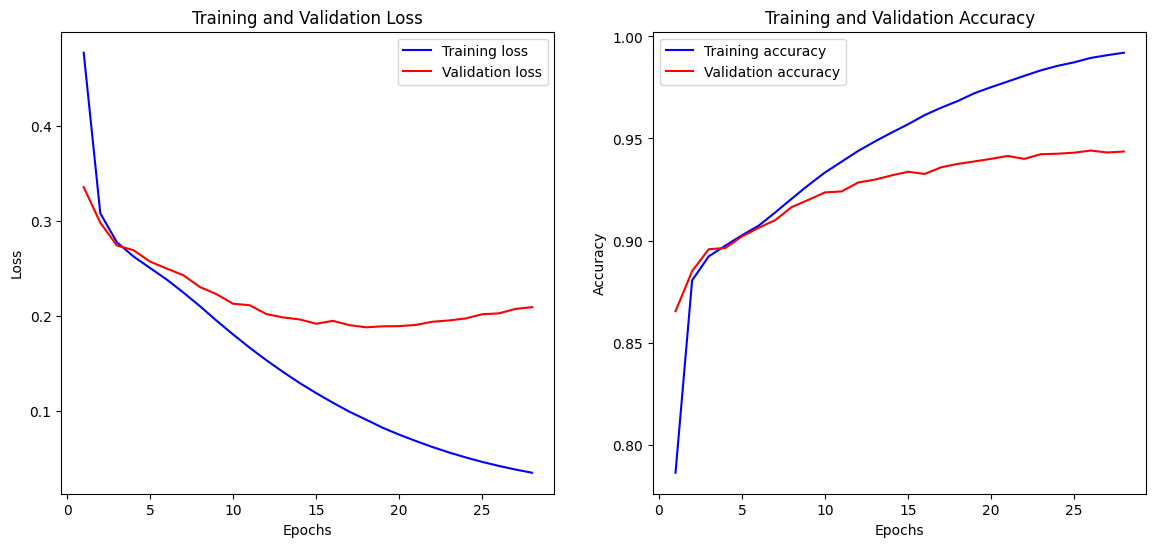

In [55]:
# Extract the loss and accuracy from the history object
train_loss = history_multiclass.history['loss']
val_loss = history_multiclass.history['val_loss']
train_accuracy = history_multiclass.history['accuracy']
val_accuracy = history_multiclass.history['val_accuracy']

# Number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the loss over epochs
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


# model comparisons


# combined code for NFM class

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout

@tf.keras.utils.register_keras_serializable()
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, loss_type='square_loss', activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.loss_type = loss_type
        self.activation = activation

        # Define layers
        self.embedding = Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = [Dense(layer_size, activation=activation) for layer_size in layers]
        self.output_layer = Dense(1, activation='sigmoid' if loss_type == 'log_loss' else 'linear')
        self.dropout_layers = [Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output

    def get_config(self):
        return {
            'feature_dim': self.feature_dim,
            'hidden_factor': self.hidden_factor,
            'layers': self.layers_config,
            'keep_prob': self.keep_prob,
            'loss_type': self.loss_type,
            'activation': self.activation,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Dense, Dropout

@tf.keras.utils.register_keras_serializable()
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, num_classes, activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.num_classes = num_classes
        self.activation = activation

        # Define layers
        self.embedding = Embedding(feature_dim, hidden_factor, mask_zero=False)
        self.hidden_layers = [Dense(layer_size, activation=activation) for layer_size in layers]
        self.dropout_layers = [Dropout(p) for p in keep_prob]
        self.output_layer = Dense(num_classes, activation='softmax')  # Multi-class output layer

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        x = tf.concat([x, fm_part], axis=1)
        output = self.output_layer(x)
        return output

    def get_config(self):
        return {
            'feature_dim': self.feature_dim,
            'hidden_factor': self.hidden_factor,
            'layers': self.layers_config,
            'keep_prob': self.keep_prob,
            'num_classes': self.num_classes,
            'activation': self.activation,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Multi class (RMSE v Dimensionality)

## setup and imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Num GPUs Available:  1


## Data Loading and Preperation

In [32]:
# Initialize data loader
path = 'data/'
dataset = 'frappe'
num_classes = 3  # Example number of classes

# Load data
loader = LoadData(path, dataset, num_classes)
feature_dim = loader.features_M

# Prepare data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = tf.keras.utils.to_categorical(np.array(data['Y']), num_classes=num_classes)  # One-hot encode labels
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare training, validation, and test data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)


In [33]:
# Prepare training, validation, and test data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (202027, 10), y_train shape: (202027, 3, 3)
X_val shape: (57722, 10), y_val shape: (57722, 3, 3)
X_test shape: (28860, 10), y_test shape: (28860, 3, 3)


## Training and Evaluation

In [ ]:
# List of embedding dimensions to test
embedding_dims = [4, 8, 16, 32, 64, 128]

# Store results for plotting
accuracy_results = []

for hidden_factor in embedding_dims:
    print(f"Training model with embedding dimension: {hidden_factor}")

    # Create NeuralFM model
    model = NeuralFM(
        feature_dim=feature_dim,
        hidden_factor=hidden_factor,
        layers=[64],
        keep_prob=[0.8, 0.5],
        num_classes=num_classes,
        activation='relu'
    )

    # Compile model for multiclass classification
    optimizer = Adam(learning_rate=0.001)  # Using Adam optimizer instead
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    tensorboard_callback = TensorBoard(log_dir=f"./logs/embedding_{hidden_factor}", profile_batch=0)

    # Train model
    history_multiclass = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
        callbacks=[early_stopping, tensorboard_callback],
        verbose=1
    )

    # Evaluate the model
    y_pred = model.predict(test_dataset)
    y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    accuracy_results.append(accuracy)
    print(f"Accuracy for embedding dimension {hidden_factor}: {accuracy}")

    # Save the model
    model_save_path = f'models/neural_fm_model_multiclass_{hidden_factor}.keras'
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")


Training model with embedding dimension: 4
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7111 - loss: 0.6091 - val_accuracy: 0.8879 - val_loss: 0.2966
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8738 - loss: 0.3146 - val_accuracy: 0.8903 - val_loss: 0.2827
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8856 - loss: 0.2841 - val_accuracy: 0.8916 - val_loss: 0.2811
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8893 - loss: 0.2700 - val_accuracy: 0.8901 - val_loss: 0.2813
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8903 - loss: 0.2644 - val_accuracy: 0.8915 - val_loss: 0.2833
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8928 - loss: 0.2593 - val_accuracy: 0.8940 - val_loss: 0.2791
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8962 - loss: 0.2513 - val_accuracy: 0.8984 - val_loss: 0.2734
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9010 - loss: 0.2414 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7612 - loss: 0.5384 - val_accuracy: 0.8834 - val_loss: 0.2906
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8813 - loss: 0.2955 - val_accuracy: 0.8877 - val_loss: 0.2823
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8864 - loss: 0.2767 - val_accuracy: 0.8901 - val_loss: 0.2798
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8903 - loss: 0.2648 - val_accuracy: 0.8956 - val_loss: 0.2727
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9001 - loss: 0.2463 - val_accuracy: 0.9045 - val_loss: 0.2578
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9090 - loss: 0.2256 - val_accuracy: 0.9117 - val_loss: 0.2443
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9185 - loss: 0.2048 - val_accuracy: 0.9178 - val_loss: 0.2376
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9272 - loss: 0.1852 - va

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7567 - loss: 0.5305 - val_accuracy: 0.8867 - val_loss: 0.2883
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8797 - loss: 0.3014 - val_accuracy: 0.8901 - val_loss: 0.2810
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8877 - loss: 0.2776 - val_accuracy: 0.8926 - val_loss: 0.2768
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8949 - loss: 0.2573 - val_accuracy: 0.9017 - val_loss: 0.2642
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9050 - loss: 0.2367 - val_accuracy: 0.9102 - val_loss: 0.2518
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9159 - loss: 0.2130 - val_accuracy: 0.9205 - val_loss: 0.2358
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9296 - loss: 0.1845 - val_accuracy: 0.9298 - val_loss: 0.2205
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9422 - loss: 0.1529 - va

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - accuracy: 0.7705 - loss: 0.5122 - val_accuracy: 0.8863 - val_loss: 0.2873
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8785 - loss: 0.3015 - val_accuracy: 0.8910 - val_loss: 0.2773
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8896 - loss: 0.2713 - val_accuracy: 0.9035 - val_loss: 0.2601
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9066 - loss: 0.2377 - val_accuracy: 0.9168 - val_loss: 0.2339
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9256 - loss: 0.1944 - val_accuracy: 0.9316 - val_loss: 0.2048
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9464 - loss: 0.1461 - val_accuracy: 0.9399 - val_loss: 0.1881
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9621 - loss: 0.1072 - val_accuracy: 0.9456 - val_loss: 0.1861
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9737 - loss: 0.0771 - va

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_11', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.7933 - loss: 0.4788 - val_accuracy: 0.8864 - val_loss: 0.2817
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8895 - loss: 0.2774 - val_accuracy: 0.9080 - val_loss: 0.2470
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9157 - loss: 0.2195 - val_accuracy: 0.9322 - val_loss: 0.1934
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9488 - loss: 0.1416 - val_accuracy: 0.9447 - val_loss: 0.1689
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9699 - loss: 0.0876 - val_accuracy: 0.9495 - val_loss: 0.1702
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9836 - loss: 0.0505 - val_accuracy: 0.9526 - val_loss: 0.1898
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9918 - loss: 0.0274 - val_accuracy: 0.9542 - val_loss: 0.2151
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9963 - loss: 0.0147 - 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_12', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7934 - loss: 0.4662 - val_accuracy: 0.8870 - val_loss: 0.2821
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8853 - loss: 0.2841 - val_accuracy: 0.9059 - val_loss: 0.2527
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9155 - loss: 0.2227 - val_accuracy: 0.9348 - val_loss: 0.1873
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9520 - loss: 0.1348 - val_accuracy: 0.9476 - val_loss: 0.1636
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9753 - loss: 0.0726 - val_accuracy: 0.9534 - val_loss: 0.1723
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9893 - loss: 0.0348 - val_accuracy: 0.9553 - val_loss: 0.1952
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9956 - loss: 0.0156 - val_accuracy: 0.9549 - val_loss: 0.2225
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9981 - loss: 0.0074 - va

## Plotting Results

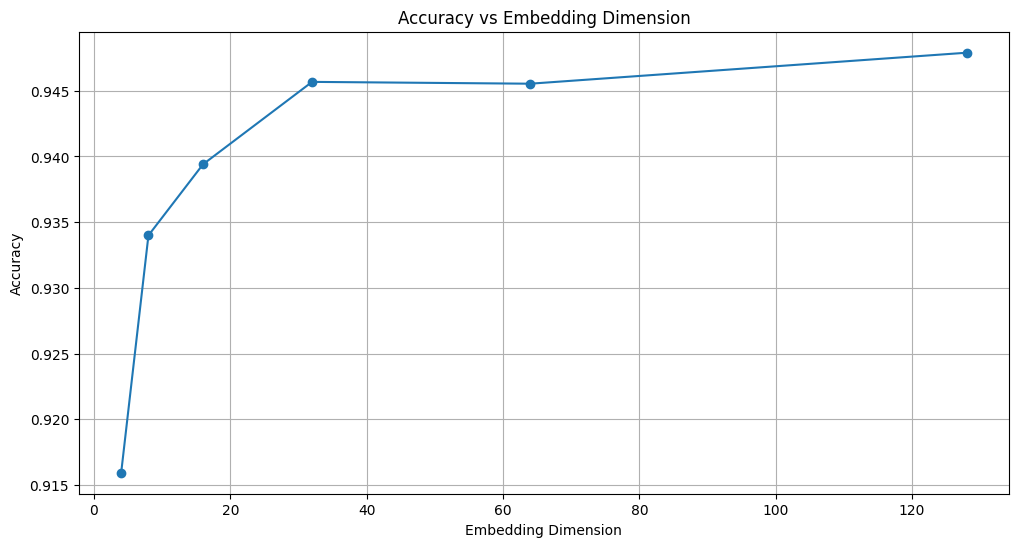

In [ ]:
# Plot Accuracy vs Embedding Dimension
plt.figure(figsize=(12, 6))
plt.plot(embedding_dims, accuracy_results, marker='o')
plt.title('Accuracy vs Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


In [ ]:
# List of embedding dimensions to evaluate
embedding_dims = [4, 8, 16, 32, 64, 128]

# Store RMSE results for plotting
rmse_results = []

for hidden_factor in embedding_dims:
    # Load the trained model
    model_path = f'models/neural_fm_model_multiclass_{hidden_factor}.keras'
    loaded_model = tf.keras.models.load_model(model_path, custom_objects={'NeuralFM': NeuralFM})
    print(f"Loaded model from {model_path}")

    # Evaluate the model on the test dataset
    y_pred = loaded_model.predict(test_dataset)

    # Convert predictions to class labels (if needed)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)  # Assuming y_test is one-hot encoded

    # Calculate RMSE
    rmse = calculate_rmse(y_test_labels, y_pred_labels)
    rmse_results.append(rmse)
    print(f"RMSE for embedding dimension {hidden_factor}: {rmse}")


Loaded model from models/neural_fm_model_multiclass_4.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
RMSE for embedding dimension 4: 0.28993272333592157
Loaded model from models/neural_fm_model_multiclass_8.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE for embedding dimension 8: 0.2569208360727405
Loaded model from models/neural_fm_model_multiclass_16.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
RMSE for embedding dimension 16: 0.24617658418889196
Loaded model from models/neural_fm_model_multiclass_32.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE for embedding dimension 32: 0.23309065689395259
Loaded model from models/neural_fm_model_multiclass_64.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE for embedding dimension 64: 0.2333877770361046
Loaded model from models/neural_fm_model_multiclass_128.keras
226/226 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
RMSE for embedding dimension 128: 0.22828414774936107


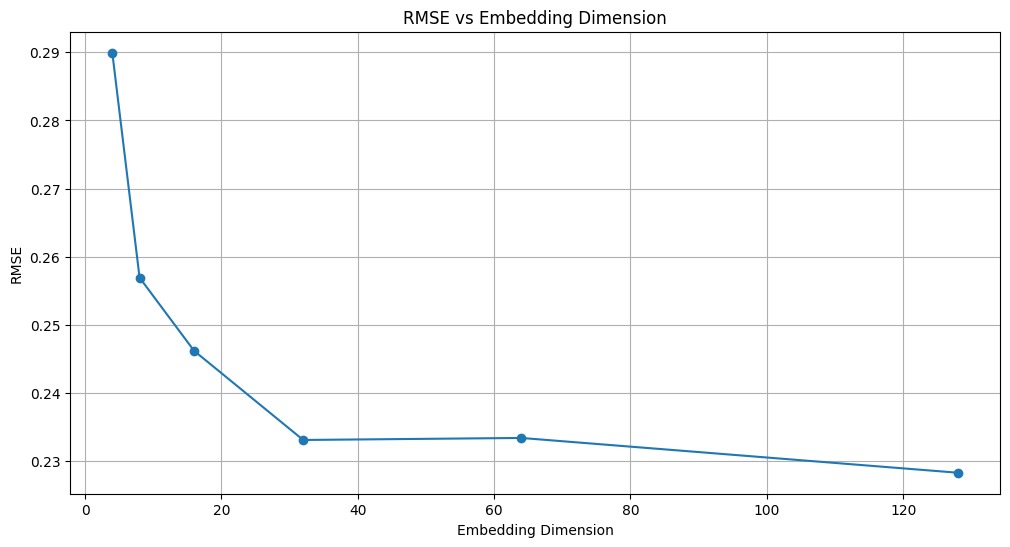

In [ ]:
import matplotlib.pyplot as plt

# Plot RMSE vs Embedding Dimension
plt.figure(figsize=(12, 6))
plt.plot(embedding_dims, rmse_results, marker='o')
plt.title('RMSE vs Embedding Dimension')
plt.xlabel('Embedding Dimension')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()


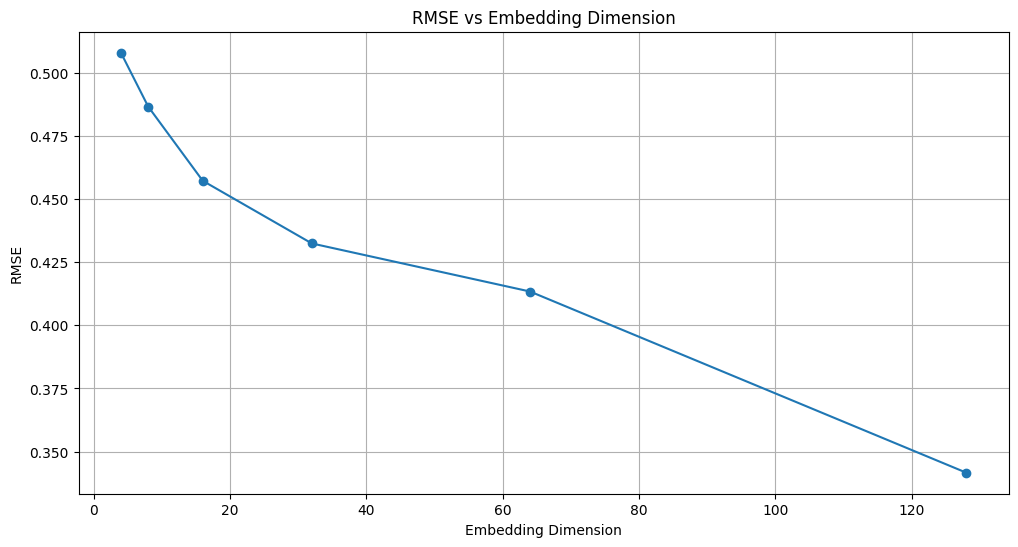

In [ ]:
# Plot RMSE vs Embedding Dimension (for regression)
if loss_type == 'square_loss':
    plt.figure(figsize=(12, 6))
    plt.plot(embedding_dims, rmse_results, marker='o')
    plt.title('RMSE vs Embedding Dimension')
    plt.xlabel('Embedding Dimension')
    plt.ylabel('RMSE')
    plt.grid(True)
    plt.show()

# implementing bi interaction layer in mnfm

# modifying the load data class


In [38]:
from tensorflow.keras.utils import to_categorical

class LoadData(object):
    def __init__(self, path, dataset, num_classes):
        self.path = path + dataset + "/"
        self.trainfile = self.path + dataset + ".train.libfm"
        self.testfile = self.path + dataset + ".test.libfm"
        self.validationfile = self.path + dataset + ".validation.libfm"
        self.features_M = self.map_features()
        self.num_classes = num_classes
        self.Train_data, self.Validation_data, self.Test_data = self.construct_data()

    def map_features(self):
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.testfile)
        self.read_features(self.validationfile)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def read_data(self, file):
        X_ = []
        Y_ = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(int(items[0]))  # Assuming labels are integers for multiclass
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        # Convert labels to one-hot encoded vectors for multiclass classification
        Y_onehot = to_categorical(Y_, num_classes=self.num_classes)
        return X_, Y_onehot

    def construct_data(self):
        # Prepare data for train, validation, and test sets
        X_train, Y_train = self.read_data(self.trainfile)
        Train_data = self.construct_dataset(X_train, Y_train)

        X_val, Y_val = self.read_data(self.validationfile)
        Validation_data = self.construct_dataset(X_val, Y_val)

        X_test, Y_test = self.read_data(self.testfile)
        Test_data = self.construct_dataset(X_test, Y_test)

        return Train_data, Validation_data, Test_data

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic


# importing libs and gpu config

In [39]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision

# Enable mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Allow memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Num GPUs Available:  1


# data loading and prep for frappe ds

In [49]:
import numpy as np
import tensorflow as tf

# Initialize data loader
path = 'data/'
dataset = 'frappe'
num_classes = 3  # Example number of classes

# Load data
loader = LoadData(path, dataset, num_classes)
feature_dim = loader.features_M
def prepare_data(data):
    # Pad sequences for X
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')

    # Use raw labels directly
    y = np.array(data['Y'])
    print(f"Raw y shape: {y.shape}")

    # Ensure correct one-hot encoding
    y = tf.keras.utils.to_categorical(y, num_classes=num_classes)  # Ensure correct one-hot encoding
    print(f"Processed y shape: {y.shape}")

    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare training, validation, and test data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)


Raw y shape: (202027, 3)
Processed y shape: (202027, 3, 3)
Raw y shape: (57722, 3)
Processed y shape: (57722, 3, 3)
Raw y shape: (28860, 3)
Processed y shape: (28860, 3, 3)


In [50]:
# Prepare training, validation, and test data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Raw y shape: (202027, 3)
Processed y shape: (202027, 3, 3)
Raw y shape: (57722, 3)
Processed y shape: (57722, 3, 3)
Raw y shape: (28860, 3)
Processed y shape: (28860, 3, 3)
X_train shape: (202027, 10), y_train shape: (202027, 3, 3)
X_val shape: (57722, 10), y_val shape: (57722, 3, 3)
X_test shape: (28860, 10), y_test shape: (28860, 3, 3)


# data loading and prep for ml ds


# model def NFM with bi interaction layer

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, Flatten
from tensorflow.keras.models import Model

class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, num_classes, activation='relu'):
        super(NeuralFM, self).__init__()
        self.embedding = Embedding(input_dim=feature_dim, output_dim=hidden_factor)
        self.bi_interaction_layer = tf.keras.layers.Lambda(self.bi_interaction)

        # Define the MLP layers
        self.mlp_layers = []
        for layer_size in layers:
            self.mlp_layers.append(Dense(layer_size, activation=activation))
            self.mlp_layers.append(tf.keras.layers.Dropout(keep_prob.pop(0)))

        self.output_layer = Dense(num_classes, activation='softmax')

    def call(self, inputs):
        X = inputs
        embeddings = self.embedding(X)

        # Apply Bi-Interaction Layer
        bi_interactions = self.bi_interaction_layer(embeddings)

        # Flatten for MLP layers
        x = Flatten()(bi_interactions)

        # Apply MLP layers
        for layer in self.mlp_layers:
            x = layer(x)

        return self.output_layer(x)

    def bi_interaction(self, embeddings):
        # Bi-Interaction Layer Implementation
        # embeddings shape: (batch_size, num_features, embedding_dim)
        interactions = tf.reduce_sum(tf.square(tf.reduce_sum(embeddings, axis=1)) - tf.reduce_sum(tf.square(embeddings), axis=1), axis=1)
        return interactions


# Training and eval

In [48]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.metrics import accuracy_score, mean_squared_error

# List of embedding dimensions to test
embedding_dims = [4, 8, 16, 32, 64, 128]

# Store results for plotting
accuracy_results = []
rmse_results = []

for hidden_factor in embedding_dims:
    print(f"Training model with embedding dimension: {hidden_factor}")

    # Create NeuralFM model with Bi-Interaction layer
    model = NeuralFM(
        feature_dim=feature_dim,
        hidden_factor=hidden_factor,
        layers=[64],
        keep_prob=[0.8, 0.5],
        num_classes=num_classes,
        activation='relu'
    )

    # Compile model for multiclass classification
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    tensorboard_callback = TensorBoard(log_dir=f"./logs/embedding_{hidden_factor}", profile_batch=0)

    # Train model
    history_multiclass = model.fit(
        train_dataset,
        epochs=200,
        validation_data=val_dataset,
        callbacks=[early_stopping, tensorboard_callback],
        verbose=1
    )

    # Evaluate the model
    y_pred = model.predict(test_dataset)
    y_test_labels = np.argmax(y_test, axis=1)  # Convert one-hot encoded y_test to class labels
    y_pred_labels = np.argmax(y_pred, axis=1)  # Convert predictions to class labels
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    accuracy_results.append(accuracy)

    # Calculate RMSE
    y_test_flat = np.argmax(y_test, axis=1)  # Flatten to get class indices
    y_pred_flat = np.argmax(y_pred, axis=1)  # Flatten to get class indices
    rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
    rmse_results.append(rmse)

    print(f"Accuracy for embedding dimension {hidden_factor}: {accuracy}")
    print(f"RMSE for embedding dimension {hidden_factor}: {rmse}")

    # Save the model
    model_save_path = f'models/neural_fm_model_multiclass_{hidden_factor}.keras'
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

# Plot Accuracy vs. Dimension
plt.figure(figsize=(12, 6))
plt.plot(embedding_dims, accuracy_results, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel('Embedding Dimension')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Embedding Dimension')
plt.grid(True)
plt.savefig('accuracy_vs_dim.png')
plt.show()

# Plot RMSE vs. Dimension
plt.figure(figsize=(12, 6))
plt.plot(embedding_dims, rmse_results, marker='o', linestyle='-', color='r')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel('Embedding Dimension')
plt.ylabel('RMSE')
plt.title('RMSE vs. Embedding Dimension')
plt.grid(True)
plt.savefig('rmse_vs_dim.png')
plt.show()


Training model with embedding dimension: 4
Epoch 1/200


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 3, 3), output.shape=(None, 3)

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_10', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7696 - loss: 0.5111 - val_accuracy: 0.8852 - val_loss: 0.3220
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8847 - loss: 0.3012 - val_accuracy: 0.8879 - val_loss: 0.2980
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8868 - loss: 0.2847 - val_accuracy: 0.8870 - val_loss: 0.2857
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8870 - loss: 0.2785 - val_accuracy: 0.8890 - val_loss: 0.2836
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8882 - loss: 0.2750 - val_accuracy: 0.8878 - val_loss: 0.2832
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8880 - loss: 0.2732 - val_accuracy: 0.8898 - val_loss: 0.2824
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8886 - loss: 0.2708 - val_accuracy: 0.8880 - val_loss: 0.2842
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8889 - loss: 0.2693 - 

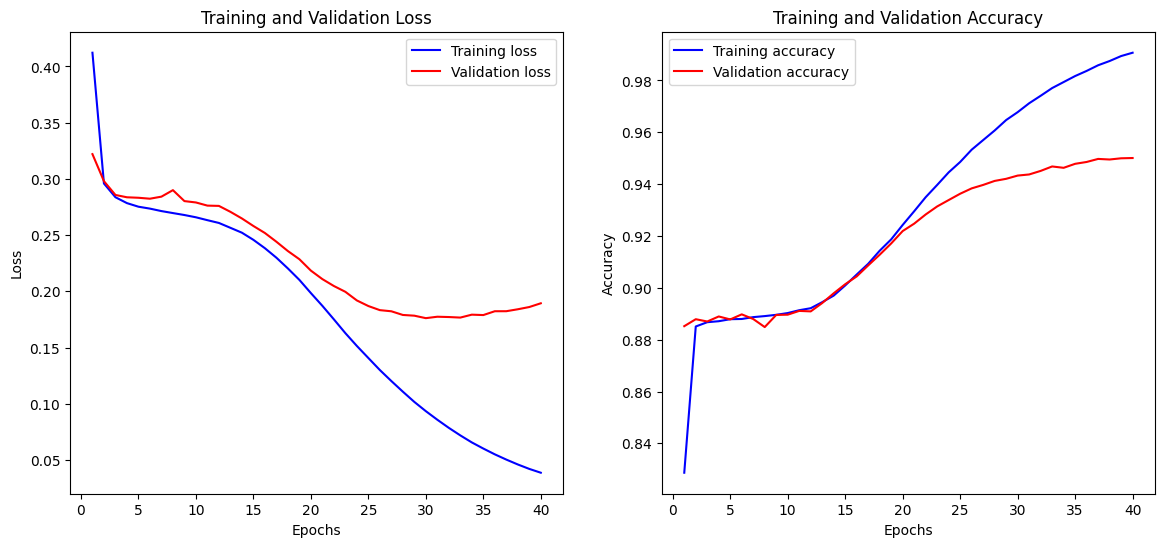

In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical

class LoadData(object):
    def __init__(self, path, dataset, num_classes):
        self.path = path + dataset + "/"
        self.trainfile = self.path + dataset + ".train.libfm"
        self.testfile = self.path + dataset + ".test.libfm"
        self.validationfile = self.path + dataset + ".validation.libfm"
        self.features_M = self.map_features()
        self.num_classes = num_classes
        self.Train_data, self.Validation_data, self.Test_data = self.construct_data()

    def map_features(self):
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.testfile)
        self.read_features(self.validationfile)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def read_data(self, file):
        X_ = []
        Y_ = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(int(items[0]))  # Assuming labels are integers for multiclass
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        # Convert labels to one-hot encoded vectors for multiclass classification
        Y_onehot = to_categorical(Y_, num_classes=self.num_classes)
        return X_, Y_onehot

    def construct_data(self):
        # Prepare data for train, validation, and test sets
        X_train, Y_train = self.read_data(self.trainfile)
        Train_data = self.construct_dataset(X_train, Y_train)

        X_val, Y_val = self.read_data(self.validationfile)
        Validation_data = self.construct_dataset(X_val, Y_val)

        X_test, Y_test = self.read_data(self.testfile)
        Test_data = self.construct_dataset(X_test, Y_test)

        return Train_data, Validation_data, Test_data

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic


class BiInteractionLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_factor, **kwargs):
        super(BiInteractionLayer, self).__init__(**kwargs)
        self.hidden_factor = hidden_factor

    def build(self, input_shape):
        self.W = self.add_weight(shape=(self.hidden_factor, self.hidden_factor),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        # Assuming inputs are embeddings with shape (batch_size, num_features, hidden_factor)
        # Compute pairwise interactions
        interaction_terms = tf.matmul(inputs, self.W)
        interaction_terms = tf.reduce_sum(interaction_terms, axis=1)
        return interaction_terms

class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, num_classes, activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.num_classes = num_classes

        # Embedding layer for factorization machine
        self.embedding = tf.keras.layers.Embedding(feature_dim, hidden_factor, mask_zero=False)

        # Bilinear interaction layer
        self.bi_interaction = BiInteractionLayer(hidden_factor)

        # Hidden layers for the neural network
        self.hidden_layers = [tf.keras.layers.Dense(layer_size, activation=activation) for layer_size in layers]

        # Output layer for multiclass classification with softmax activation
        self.output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

        # Dropout layers
        self.dropout_layers = [tf.keras.layers.Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        # Embedding lookup
        x = self.embedding(inputs)

        # FM part: Interaction terms between features
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        # Bilinear Interaction Part
        bi_interaction_part = self.bi_interaction(x)

        # NN part: Apply hidden layers
        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        # Concatenate FM, Bi-Interaction and NN part
        x = tf.concat([x, fm_part, bi_interaction_part], axis=1)

        # Output layer (softmax for multiclass classification)
        output = self.output_layer(x)
        return output


# Initialize data loader
path = 'data/'
dataset = 'frappe'
num_classes = 3  # Example number of classes

# Load data
loader = LoadData(path, dataset, num_classes)
feature_dim = loader.features_M
hidden_factor = 64
layers = [64]
keep_prob = [0.8, 0.5]

# Create NeuralFM model
model = NeuralFM(
    feature_dim=feature_dim,
    hidden_factor=hidden_factor,
    layers=layers,
    keep_prob=keep_prob,
    num_classes=num_classes,
    activation='relu'
)

# Compile model for multiclass classification
optimizer = Adagrad(learning_rate=0.05)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Prepare training, validation, and test data
X_train, y_train = prepare_data(loader.Train_data)
X_val, y_val = prepare_data(loader.Validation_data)
X_test, y_test = prepare_data(loader.Test_data)

batch_size = 128
train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

# Train model
history_multiclass = model.fit(
    train_dataset,
    epochs=200,
    validation_data=val_dataset,
    callbacks=[early_stopping, tensorboard_callback],
    verbose=1
)

# Save model
model.save('neural_fm_model_multiclass.keras')


# Extract the loss and accuracy from the history object
train_loss = history_multiclass.history['loss']
val_loss = history_multiclass.history['val_loss']
train_accuracy = history_multiclass.history['accuracy']
val_accuracy = history_multiclass.history['val_accuracy']

# Number of epochs
epochs = range(1, len(train_loss) + 1)

# Plot the loss over epochs
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot the accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
class BiInteractionLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_factor, **kwargs):
        super(BiInteractionLayer, self).__init__(**kwargs)
        self.hidden_factor = hidden_factor

    def build(self, input_shape):
        # Input shape should be (batch_size, num_features, embedding_dim)
        embedding_dim = input_shape[2][-1]  # Extract embedding dimension
        self.W = self.add_weight(shape=(embedding_dim, self.hidden_factor),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        # Compute pairwise interactions
        interaction_terms = tf.matmul(inputs, self.W)
        interaction_terms = tf.reduce_sum(interaction_terms, axis=1)
        return interaction_terms


Training with embedding dimension: 8
Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_13', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7703 - loss: 0.5113 - val_accuracy: 0.8868 - val_loss: 0.3049
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8863 - loss: 0.2935 - val_accuracy: 0.8879 - val_loss: 0.2939
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8879 - loss: 0.2794 - val_accuracy: 0.8885 - val_loss: 0.2835
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8870 - loss: 0.2756 - val_accuracy: 0.8868 - val_loss: 0.2858
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8880 - loss: 0.2728 - val_accuracy: 0.8892 - val_loss: 0.2826
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8882 - loss: 0.2709 - val_accuracy: 0.8884 - val_loss: 0.2844
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8882 - loss: 0.2693 - val_accuracy: 0.8891 - val_loss: 0.2825
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8890 - loss: 0.2680 - va

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_14', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7763 - loss: 0.4984 - val_accuracy: 0.8790 - val_loss: 0.3106
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8859 - loss: 0.2934 - val_accuracy: 0.8884 - val_loss: 0.2866
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8869 - loss: 0.2814 - val_accuracy: 0.8886 - val_loss: 0.2842
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8882 - loss: 0.2751 - val_accuracy: 0.8883 - val_loss: 0.2830
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8878 - loss: 0.2726 - val_accuracy: 0.8849 - val_loss: 0.2946
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8881 - loss: 0.2706 - val_accuracy: 0.8888 - val_loss: 0.2819
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8890 - loss: 0.2680 - val_accuracy: 0.8860 - val_loss: 0.2865
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8891 - loss: 0.2667 - v

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_15', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7733 - loss: 0.5048 - val_accuracy: 0.8688 - val_loss: 0.3294
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8854 - loss: 0.2962 - val_accuracy: 0.8875 - val_loss: 0.2860
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8870 - loss: 0.2818 - val_accuracy: 0.8880 - val_loss: 0.2831
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8880 - loss: 0.2766 - val_accuracy: 0.8877 - val_loss: 0.2849
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8881 - loss: 0.2739 - val_accuracy: 0.8882 - val_loss: 0.2825
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8881 - loss: 0.2722 - val_accuracy: 0.8880 - val_loss: 0.2827
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8888 - loss: 0.2699 - val_accuracy: 0.8882 - val_loss: 0.2850
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8887 - loss: 0.2697 - v

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_16', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.7722 - loss: 0.5081 - val_accuracy: 0.8608 - val_loss: 0.3617
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8839 - loss: 0.3014 - val_accuracy: 0.8852 - val_loss: 0.2920
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8867 - loss: 0.2846 - val_accuracy: 0.8873 - val_loss: 0.2860
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8873 - loss: 0.2788 - val_accuracy: 0.8872 - val_loss: 0.2926
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8881 - loss: 0.2754 - val_accuracy: 0.8886 - val_loss: 0.2844
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8879 - loss: 0.2738 - val_accuracy: 0.8854 - val_loss: 0.2885
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8887 - loss: 0.2726 - val_accuracy: 0.8880 - val_loss: 0.2841
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8888 - loss: 0.2710 - val

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'neural_fm_17', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


1579/1579 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.7721 - loss: 0.5127 - val_accuracy: 0.8811 - val_loss: 0.3264
Epoch 2/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.8822 - loss: 0.3056 - val_accuracy: 0.8806 - val_loss: 0.3012
Epoch 3/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8863 - loss: 0.2864 - val_accuracy: 0.8892 - val_loss: 0.2866
Epoch 4/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8877 - loss: 0.2793 - val_accuracy: 0.8895 - val_loss: 0.2846
Epoch 5/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8879 - loss: 0.2768 - val_accuracy: 0.8887 - val_loss: 0.2874
Epoch 6/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8882 - loss: 0.2750 - val_accuracy: 0.8879 - val_loss: 0.2833
Epoch 7/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8875 - loss: 0.2733 - val_accuracy: 0.8874 - val_loss: 0.2838
Epoch 8/200
1579/1579 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.8887 - loss: 0.2708 - 

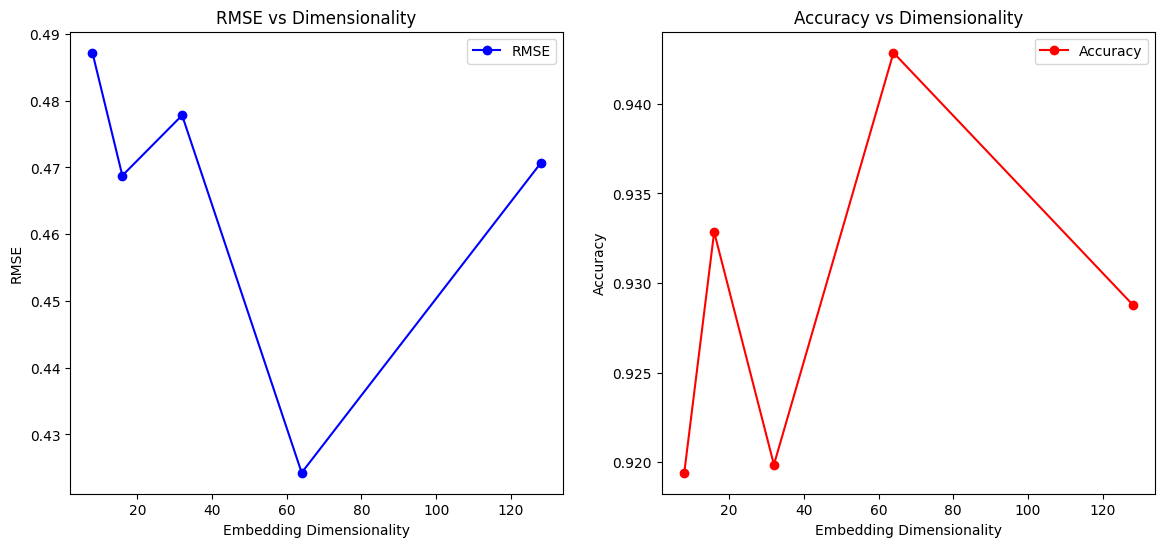

In [59]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.utils import to_categorical

# Data Loading Class
class LoadData(object):
    def __init__(self, path, dataset, num_classes):
        self.path = path + dataset + "/"
        self.trainfile = self.path + dataset + ".train.libfm"
        self.testfile = self.path + dataset + ".test.libfm"
        self.validationfile = self.path + dataset + ".validation.libfm"
        self.features_M = self.map_features()
        self.num_classes = num_classes
        self.Train_data, self.Validation_data, self.Test_data = self.construct_data()

    def map_features(self):
        self.features = {}
        self.read_features(self.trainfile)
        self.read_features(self.testfile)
        self.read_features(self.validationfile)
        return len(self.features)

    def read_features(self, file):
        with open(file) as f:
            line = f.readline()
            i = len(self.features)
            while line:
                items = line.strip().split(' ')
                for item in items[1:]:
                    if item not in self.features:
                        self.features[item] = i
                        i += 1
                line = f.readline()

    def read_data(self, file):
        X_ = []
        Y_ = []
        with open(file) as f:
            line = f.readline()
            while line:
                items = line.strip().split(' ')
                Y_.append(int(items[0]))  # Assuming labels are integers for multiclass
                X_.append([self.features[item] for item in items[1:]])
                line = f.readline()
        # Convert labels to one-hot encoded vectors for multiclass classification
        Y_onehot = to_categorical(Y_, num_classes=self.num_classes)
        return X_, Y_onehot

    def construct_data(self):
        # Prepare data for train, validation, and test sets
        X_train, Y_train = self.read_data(self.trainfile)
        Train_data = self.construct_dataset(X_train, Y_train)

        X_val, Y_val = self.read_data(self.validationfile)
        Validation_data = self.construct_dataset(X_val, Y_val)

        X_test, Y_test = self.read_data(self.testfile)
        Test_data = self.construct_dataset(X_test, Y_test)

        return Train_data, Validation_data, Test_data

    def construct_dataset(self, X_, Y_):
        Data_Dic = {}
        X_lens = [len(line) for line in X_]
        indexs = np.argsort(X_lens)
        Data_Dic['Y'] = [Y_[i] for i in indexs]
        Data_Dic['X'] = [X_[i] for i in indexs]
        return Data_Dic

# BiInteraction Layer
class BiInteractionLayer(tf.keras.layers.Layer):
    def __init__(self, hidden_factor, **kwargs):
        super(BiInteractionLayer, self).__init__(**kwargs)
        self.hidden_factor = hidden_factor

    def build(self, input_shape):
        # Input shape should be (batch_size, num_features, embedding_dim)
        embedding_dim = input_shape[2]  # Correctly extract embedding dimension
        self.W = self.add_weight(shape=(embedding_dim, self.hidden_factor),
                                 initializer='glorot_uniform',
                                 trainable=True)

    def call(self, inputs):
        # Compute pairwise interactions
        interaction_terms = tf.matmul(inputs, self.W)
        interaction_terms = tf.reduce_sum(interaction_terms, axis=1)
        return interaction_terms

# NeuralFM Model
class NeuralFM(tf.keras.Model):
    def __init__(self, feature_dim, hidden_factor, layers, keep_prob, num_classes, activation='relu'):
        super(NeuralFM, self).__init__()
        self.feature_dim = feature_dim
        self.hidden_factor = hidden_factor
        self.layers_config = layers
        self.keep_prob = keep_prob
        self.num_classes = num_classes

        # Embedding layer for factorization machine
        self.embedding = tf.keras.layers.Embedding(feature_dim, hidden_factor, mask_zero=False)

        # Bilinear interaction layer
        self.bi_interaction = BiInteractionLayer(hidden_factor)

        # Hidden layers for the neural network
        self.hidden_layers = [tf.keras.layers.Dense(layer_size, activation=activation) for layer_size in layers]

        # Output layer for multiclass classification with softmax activation
        self.output_layer = tf.keras.layers.Dense(num_classes, activation='softmax')

        # Dropout layers
        self.dropout_layers = [tf.keras.layers.Dropout(p) for p in keep_prob]

    def call(self, inputs, training=False):
        # Embedding lookup
        x = self.embedding(inputs)

        # FM part: Interaction terms between features
        fm_part = tf.reduce_sum(x, axis=1) ** 2 - tf.reduce_sum(x ** 2, axis=1)
        fm_part = 0.5 * tf.reduce_sum(fm_part, axis=1, keepdims=True)

        # Bilinear Interaction Part
        bi_interaction_part = self.bi_interaction(x)

        # NN part: Apply hidden layers
        x = tf.reduce_sum(x, axis=1)
        for layer, dropout in zip(self.hidden_layers, self.dropout_layers):
            x = layer(x)
            if training:
                x = dropout(x)

        # Concatenate FM, Bi-Interaction and NN part
        x = tf.concat([x, fm_part, bi_interaction_part], axis=1)

        # Output layer (softmax for multiclass classification)
        output = self.output_layer(x)
        return output

# Training and Evaluation
def train_and_evaluate(embedding_dims, loader, num_classes):
    rmse_results = []
    accuracy_results = []
    for dim in embedding_dims:
        print(f"Training with embedding dimension: {dim}")

        # Create NeuralFM model
        model = NeuralFM(
            feature_dim=loader.features_M,
            hidden_factor=dim,
            layers=[64],
            keep_prob=[0.8, 0.5],
            num_classes=num_classes,
            activation='relu'
        )

        # Compile model
        optimizer = Adagrad(learning_rate=0.05)
        model.compile(
            optimizer=optimizer,
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Prepare datasets
        X_train, y_train = prepare_data(loader.Train_data)
        X_val, y_val = prepare_data(loader.Validation_data)
        X_test, y_test = prepare_data(loader.Test_data)

        batch_size = 128
        train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
        val_dataset = create_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
        test_dataset = create_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

        # Define callbacks
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        tensorboard_callback = TensorBoard(log_dir="./logs", profile_batch=0)

        # Train model
        history = model.fit(
            train_dataset,
            epochs=200,
            validation_data=val_dataset,
            callbacks=[early_stopping, tensorboard_callback],
            verbose=1
        )

        # Evaluate model
        val_loss, val_accuracy = model.evaluate(val_dataset, verbose=0)
        test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)

        # Calculate RMSE (Root Mean Squared Error)
        rmse = np.sqrt(val_loss)

        rmse_results.append(rmse)
        accuracy_results.append(test_accuracy)

    return rmse_results, accuracy_results, embedding_dims

# Prepare data
def prepare_data(data):
    X = tf.keras.preprocessing.sequence.pad_sequences(data['X'], padding='post')
    y = np.array(data['Y'])
    return X, y

def create_dataset(X, y, batch_size=128, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Initialize data loader
path = 'data/'
dataset = 'frappe'
num_classes = 3  # Example number of classes

loader = LoadData(path, dataset, num_classes)

# Embedding dimensions to evaluate
embedding_dims = [8, 16, 32, 64, 128]

# Train and evaluate models
rmse_results, accuracy_results, embedding_dims = train_and_evaluate(embedding_dims, loader, num_classes)

# Plot RMSE vs Dimensionality
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(embedding_dims, rmse_results, 'bo-', label='RMSE')
plt.title('RMSE vs Dimensionality')
plt.xlabel('Embedding Dimensionality')
plt.ylabel('RMSE')
plt.legend()

# Plot Accuracy vs Dimensionality
plt.subplot(1, 2, 2)
plt.plot(embedding_dims, accuracy_results, 'ro-', label='Accuracy')
plt.title('Accuracy vs Dimensionality')
plt.xlabel('Embedding Dimensionality')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
